In [38]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter
import string
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [39]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'

# Read the CSV file into a DataFrame.
# If the file does not have headers, specify header=None and assign a column name.
df = pd.read_csv(train_file_path, header=None, names=['sentence'])
df_test = pd.read_csv(test_file_path, header=None, names=['sentence'])

#### EDA on train dataset

In [40]:
# DataFrame structure and general info
print("Training DataFrame Info:")
df.info()

# Display summary statistics
print("\nDataFrame Summary Statistics:")
print(df.describe(include='all'))

# Check the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(df.head())

Training DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52499 entries, 0 to 52498
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  52499 non-null  object
dtypes: object(1)
memory usage: 410.3+ KB

DataFrame Summary Statistics:
            sentence
count          52499
unique         51134
top     [('.', '.')]
freq              44

First Few Rows:
                                            sentence
0  [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM...
1  [('The', 'DET'), ('industry', 'NOUN'), ('has',...
2  [('Love', 'VERB'), ('this', 'DET'), ('place', ...
3  [('This', 'DET'), ('problem', 'NOUN'), ('of', ...
4  [('Esso', 'PROPN'), ('said', 'VERB'), ('0', 'X...


#### EDA on test dataset

In [41]:
# DataFrame structure and general info
print("Testing DataFrame Info:")
df_test.info()

# Display summary statistics
print("\nDataFrame Summary Statistics:")
print(df_test.describe(include='all'))

# Check the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(df_test.head())

Testing DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65625 entries, 0 to 65624
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  65625 non-null  object
dtypes: object(1)
memory usage: 512.8+ KB

DataFrame Summary Statistics:
            sentence
count          65625
unique         63760
top     [('.', '.')]
freq              53

First Few Rows:
                                            sentence
0                                  [('DF', 'PROPN')]
1  [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM...
2  [('The', 'DET'), ('industry', 'NOUN'), ('has',...
3  [('Love', 'VERB'), ('this', 'DET'), ('place', ...
4  [('This', 'DET'), ('problem', 'NOUN'), ('of', ...


#### EDA: Comparision between train and test dataset


Length of Train Dataset before dropping duplicates: 52499
Length of Test Dataset before dropping duplicates: 65625

Length of Train Dataset after dropping duplicates: 51134
Length of Test Dataset after dropping duplicates: 63760

Unique to Train: 0
Unique to Test: 12626
Common rows: 51134


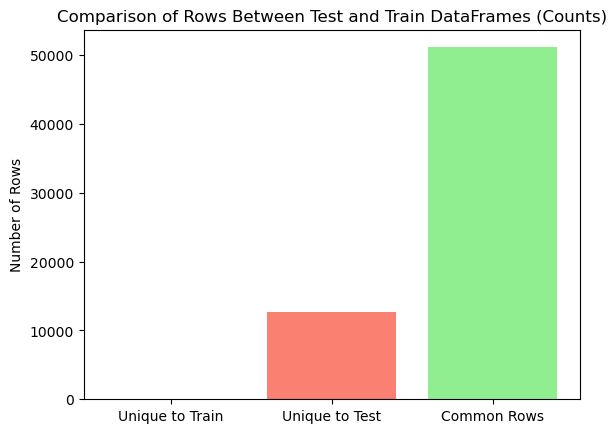


Percentage of Unique to Train: 0.00%
Percentage of Unique to Test: 10.99%
Percentage of Common Rows: 44.51%


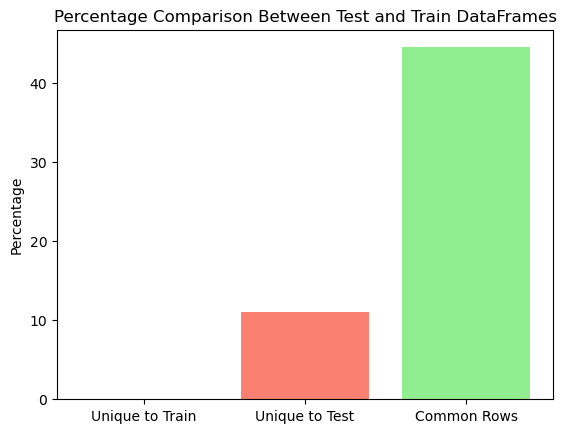

Train dataset assertion passed ✅
Test dataset assertion passed ✅
Total row counts assertion passed ✅


In [42]:
# Drop Duplicates and Compare
print("\nLength of Train Dataset before dropping duplicates:", len(df))
print("Length of Test Dataset before dropping duplicates:", len(df_test))

df = df.drop_duplicates(subset=['sentence'])
df_test = df_test.drop_duplicates(subset=['sentence'])

print("\nLength of Train Dataset after dropping duplicates:", len(df))
print("Length of Test Dataset after dropping duplicates:", len(df_test))

unique_to_df1 = df[~df['sentence'].isin(df_test['sentence'])]
unique_to_df2 = df_test[~df_test['sentence'].isin(df['sentence'])]
common_rows = pd.merge(df, df_test, on='sentence')

# Create counts for visualization
counts = {
    'Unique to Train': len(unique_to_df1),
    'Unique to Test': len(unique_to_df2),
    'Common Rows': len(common_rows)
}

print("\nUnique to Train:", len(unique_to_df1))
print("Unique to Test:", len(unique_to_df2))
print("Common rows:", len(common_rows))

# Plotting comparison for counts
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Comparison of Rows Between Test and Train DataFrames (Counts)")
plt.ylabel("Number of Rows")
plt.show()

# Calculate percentages for better insight
total_rows = len(df) + len(df_test)
percentages = {key: (value / total_rows) * 100 for key, value in counts.items()}

print("\nPercentage of Unique to Train: {:.2f}%".format(percentages['Unique to Train']))
print("Percentage of Unique to Test: {:.2f}%".format(percentages['Unique to Test']))
print("Percentage of Common Rows: {:.2f}%".format(percentages['Common Rows']))

# Plotting percentage comparison
plt.bar(percentages.keys(), percentages.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Percentage Comparison Between Test and Train DataFrames")
plt.ylabel("Percentage")
plt.show()

# Assertions for sanity checks
assert len(df) == len(unique_to_df1) + len(common_rows), "Mismatch in Train dataset counts!"
print("Train dataset assertion passed ✅")

assert len(df_test) == len(unique_to_df2) + len(common_rows), "Mismatch in Test dataset counts!"
print("Test dataset assertion passed ✅")

assert sum(counts.values()) == len(df) + len(df_test) - len(common_rows), "Total row counts assertion passed ✅"
print("Total row counts assertion passed ✅")



#### Sentence Parsing
Converting the given sentence string to a list of tuples.

In [43]:
df['parsed_sentence'] = df['sentence'].apply(lambda x: ast.literal_eval(x))
df_test['parsed_sentence'] = df_test['sentence'].apply(lambda x: ast.literal_eval(x))

#### EDA on train dataset

In [44]:
num_sentences = len(df)
print("\nTotal number of sentences:", num_sentences)
# Display DataFrame information
print("\nDataFrame Info:")
print(df.info())


Total number of sentences: 51134

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 51134 entries, 0 to 52498
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence         51134 non-null  object
 1   parsed_sentence  51134 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


In [45]:
# print the first row with all columns
print("After converting from string to list of tuples, the parsed sentence in first row:")
print(df['parsed_sentence'].iloc[0])
print(type(df['parsed_sentence'].iloc[0]))
# print more info about the column parsed. like, the datatype and stuff
# print(df['parsed'].apply(type).value_counts())
print("\nFirst value in first row of the parsed column:")
print(df['parsed_sentence'].iloc[0][0])
print(type(df['parsed_sentence'].iloc[0][0]))

After converting from string to list of tuples, the parsed sentence in first row:
[('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM', 'NOUN')]
<class 'list'>

First value in first row of the parsed column:
('03/01/2001', 'NUM')
<class 'tuple'>


In [46]:
# Calculate sentence lengths (number of word-tag pairs per sentence)
df['sentence_length'] = df['parsed_sentence'].apply(lambda sentence: len(sentence))
print("\nSentence length statistics:")
print(df['sentence_length'].describe())

print("\nLength of sentences for first few rows:")
print(df['sentence_length'].head())


Sentence length statistics:
count    51134.000000
mean        20.555501
std         13.278339
min          1.000000
25%         11.000000
50%         18.000000
75%         28.000000
max        180.000000
Name: sentence_length, dtype: float64

Length of sentences for first few rows:
0     3
1    10
2     4
3    23
4    10
Name: sentence_length, dtype: int64


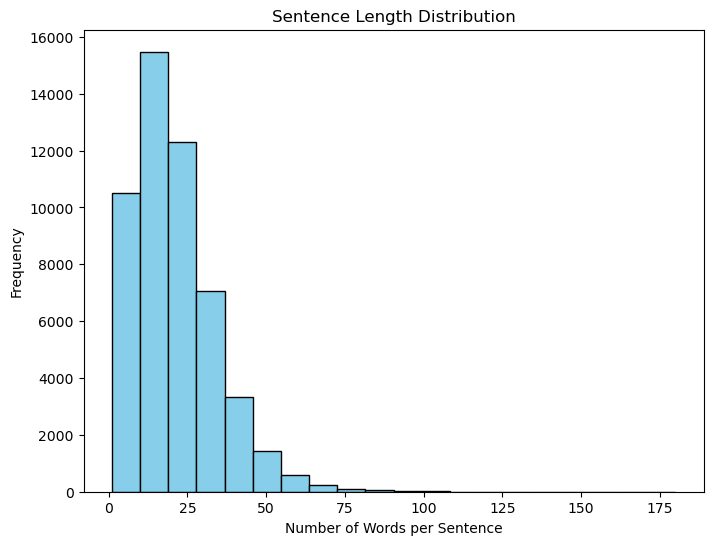

In [47]:
# Visualize the distribution of sentence lengths
plt.figure(figsize=(8, 6))
df['sentence_length'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

#### Separating word and corresponding tag pair for each word in all sentences 

In [48]:
# Create a list of dictionaries where each dictionary represents a word-tag pair.
records = []
for sentence in df['parsed_sentence']:
    for word, tag in sentence:
        records.append({'word': word, 'tag': tag})

# Create a new DataFrame from the records.
df_words = pd.DataFrame(records)
print(df_words)

               word    tag
0        03/01/2001    NUM
1             01:35    NUM
2                PM   NOUN
3               The    DET
4          industry   NOUN
...             ...    ...
1051080           .  PUNCT
1051081           B    ADJ
1051082           &  CCONJ
1051083           w    ADJ
1051084           .  PUNCT

[1051085 rows x 2 columns]


#### EDA: word-tag distribution

In [49]:
# Check basic information and types
print("Dataset Info:")
df_words.info()

# Summary statistics
print("\nDataset Summary Statistics:")
print(df_words.describe(include='all'))

# Check for missing values
print("\nMissing Values:")
print(df_words.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051085 entries, 0 to 1051084
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   word    1051085 non-null  object
 1   tag     1051085 non-null  object
dtypes: object(2)
memory usage: 16.0+ MB

Dataset Summary Statistics:
           word      tag
count   1051085  1051085
unique    58110       21
top         the     NOUN
freq      54411   239116

Missing Values:
word    0
tag     0
dtype: int64


Length of tag distribution: 21

Tag Frequency Distribution:
tag
NOUN     239116
VERB     151350
ADP      124875
DET      115502
.         94258
ADJ       76492
ADV       48887
PRON      48510
CONJ      27227
PUNCT     23089
PROPN     18938
PRT       18667
NUM       16778
X         13147
AUX       12563
PART       7514
CCONJ      6446
SCONJ      3666
_          2643
INTJ        712
SYM         705
Name: count, dtype: int64


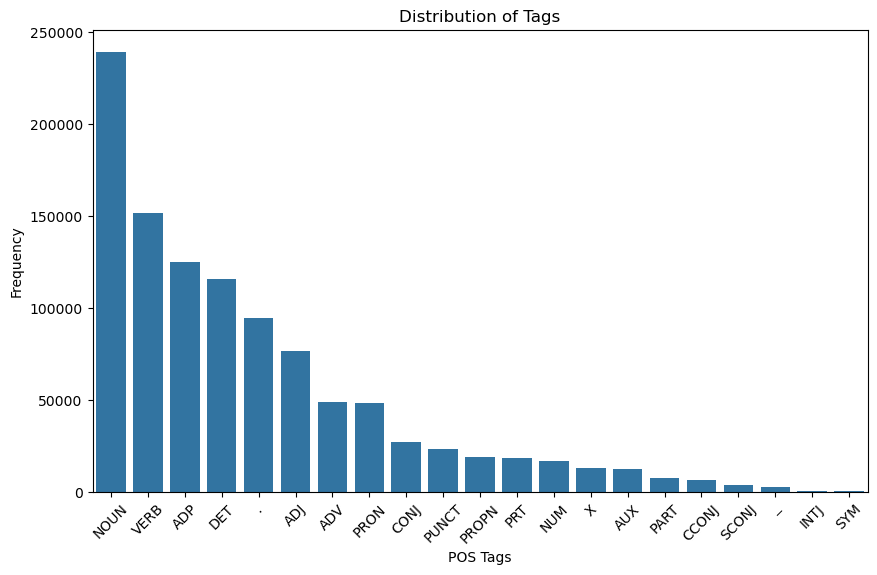

In [50]:
# Count the frequency of each tag
tag_distribution = df_words['tag'].value_counts()
print("Length of tag distribution:", len(tag_distribution))
print("\nTag Frequency Distribution:")
print(tag_distribution)

# Plot the distribution of tags
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_distribution.index, y=tag_distribution.values)
plt.title("Distribution of Tags")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()



Top 10 Most Frequent Words:
word
the     54411
,       48728
.       42284
of      31048
and     24549
to      23850
a       19556
in      17670
is      10267
that     9427
Name: count, dtype: int64


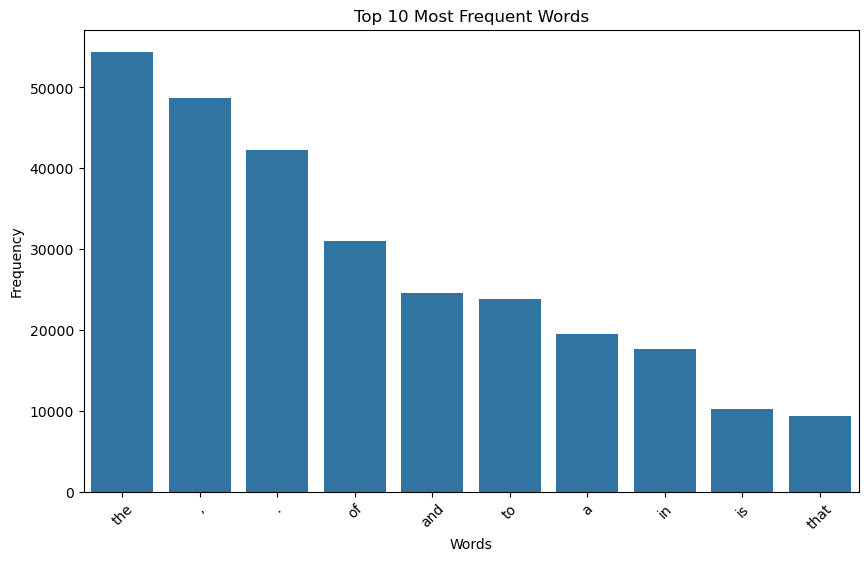

In [51]:
# Count the frequency of words
word_frequency = df_words['word'].value_counts()
print("\nTop 10 Most Frequent Words:")
print(word_frequency.head(10))

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
sns.barplot(x=word_frequency.head(10).index, y=word_frequency.head(10).values)
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


### Step-2. Pre-Processing

#### Text Cleaning
- Converting to Lowercase
- Removing URLs if any using regex library
- Removing non-word and non-whitespace characters: punctuations marks, symbols, other special characters

In [52]:

def clean_word(word):
    # Convert to lowercase
    word = word.lower()
    
    # Remove URLs
    word = re.sub(r'http\S+|www\S+|https\S+', '', word)
    
    # Remove non-word and non-whitespace characters, but not tags like '.'
    word = re.sub(r'[^\w\s]', '', word)
    
    # Remove alphanumeric words containing digits but leave words like underscores
    word = re.sub('\b\w*\d\w*\b', '', word)
    
    # Remove words that consist only of underscores
    if re.match(r'^\_+$', word):
        return None  # Remove this word if it consists of only underscores

    # Return cleaned word if it's not purely numeric and not empty
    return word if word else None

def clean_sentence(sentence):
    cleaned_sentence = []
    for word, tag in sentence:
        # Only clean the word, keep the tag unchanged
        cleaned_word = clean_word(word)
        if cleaned_word:  # Keep valid cleaned words
            cleaned_sentence.append((cleaned_word, tag))
    return cleaned_sentence

# Apply the updated cleaning function to the parsed sentences
df['parsed_sentence'] = df['parsed_sentence'].apply(clean_sentence)
# Doing it on test dataset also
df_test['parsed_sentence'] = df_test['parsed_sentence'].apply(clean_sentence)

In [53]:
# Extract all words and tags from the parsed sentences
all_words = [word for sentence in df['parsed_sentence'] for word, _ in sentence]
all_tags = [tag for sentence in df['parsed_sentence'] for __, tag in sentence]
print("Total words: ", len(all_words), "Total tags: ", len(all_tags))
# Get unique words and tags
unique_words = set(all_words)
unique_tags = set(all_tags)

print(f"Total Unique Words: {len(unique_words)}")
print(f"Total Unique Tags: {len(unique_tags)}")
print("Few Unique Words:", list(unique_words)[:10])
print("\nFew Unique Tags:", list(unique_tags))


Total words:  924007 Total tags:  924007
Total Unique Words: 48195
Total Unique Tags: 19
Few Unique Words: ['sluggishness', 'regions', 'invulnerability', 'nbc', 'refrained', 'abbreviations', 'outbreaks', 'classified', 'aka', 'specification']

Few Unique Tags: ['SYM', '_', 'INTJ', 'ADP', 'ADV', 'ADJ', 'NUM', 'PRT', 'DET', 'CCONJ', 'SCONJ', 'CONJ', 'PROPN', 'PRON', 'X', 'AUX', 'VERB', 'PART', 'NOUN']


In [54]:
# Create dictionaries mapping words and tags to indices
word_to_index = {word: idx for idx, word in enumerate(sorted(unique_words))}
tag_to_index = {tag: idx for idx, tag in enumerate(sorted(unique_tags))}

print("\nSample Word to Index Mapping:", list(word_to_index.items())[:10])
print("\nSample Tag to Index Mapping:", list(tag_to_index.items()))



Sample Word to Index Mapping: [('0', 0), ('0000108806', 1), ('0001', 2), ('0002', 3), ('00022', 4), ('0005', 5), ('00076', 6), ('000s', 7), ('0025in', 8), ('0039', 9)]

Sample Tag to Index Mapping: [('ADJ', 0), ('ADP', 1), ('ADV', 2), ('AUX', 3), ('CCONJ', 4), ('CONJ', 5), ('DET', 6), ('INTJ', 7), ('NOUN', 8), ('NUM', 9), ('PART', 10), ('PRON', 11), ('PROPN', 12), ('PRT', 13), ('SCONJ', 14), ('SYM', 15), ('VERB', 16), ('X', 17), ('_', 18)]


#### Stop word removal

In [55]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define the stop words set
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# Count the total stop words before removal
total_stop_words_before = sum(
    word.lower() in stop_words for sentence in df['parsed_sentence'] for word, _ in sentence
)

print(f"Total number of stop words before removal: {total_stop_words_before}")

Total number of stop words before removal: 423092


In [57]:
def remove_stop_words(sentence):
    # Remove stop words from the sentence while keeping tags intact
    return [(word, tag) for word, tag in sentence if word.lower() not in stop_words]

# Apply the stop word removal function
df['parsed_sentence'] = df['parsed_sentence'].apply(remove_stop_words)
df_test['parsed_sentence'] = df_test['parsed_sentence'].apply(remove_stop_words)

In [58]:
# Count the total stop words after removal
total_stop_words_after = sum(
    word.lower() in stop_words for sentence in df['parsed_sentence'] for word, _ in sentence
)

print(f"Total number of stop words after removal: {total_stop_words_after}")


Total number of stop words after removal: 0


#### Viterbi Algorithm

In [59]:
from collections import defaultdict

# Extract unique tags and words from the parsed sentences to account all the unique tags and words
tags = set()
words = set()

for sentence in df['parsed_sentence']:
    for item in sentence:
        word, tag = item
        tags.add(tag)
        words.add(word)

tags = list(tags)
words = list(words)

# Compute transition probabilities P(tag2 | tag1)
transition_counts = defaultdict(lambda: defaultdict(int))
tag_counts = defaultdict(int)

for sentence in df['parsed_sentence']:
    prev_tag = None
    for _, tag in sentence:
        tag_counts[tag] += 1
        if prev_tag is not None:
            transition_counts[prev_tag][tag] += 1
        prev_tag = tag

transition_probs = {
    tag1: {tag2: (transition_counts[tag1][tag2] + 1) / (tag_counts[tag1] + len(tags))
           for tag2 in tags}
    for tag1 in tags
}

# Compute emission probabilities P(word | tag)
emission_counts = defaultdict(lambda: defaultdict(int))

for sentence in df['parsed_sentence']:
    for word, tag in sentence:
        emission_counts[tag][word] += 1

emission_probs = {
    tag: {word: (emission_counts[tag][word] + 1) / (tag_counts[tag] + len(words))
          for word in words}
    for tag in tags
}

# Compute initial probabilities P(tag | start)
start_counts = defaultdict(int)
total_sentences = len(df['parsed_sentence'])

for sentence in df['parsed_sentence']:
    if sentence:  # Ensure the sentence is not empty
        first_tag = sentence[0][1]
        start_counts[first_tag] += 1

start_probs = {
    tag: (start_counts[tag] + 1) / (total_sentences + len(tags))
    for tag in tags
}

In [60]:
def viterbi_algorithm(sentence, tags, transition_probs, emission_probs, start_probs):
    V = [{}]  # Viterbi matrix (list of dictionaries)
    backpointer = [{}]  # Backpointer matrix
    
    # Initialize the first column of the Viterbi matrix
    for tag in tags:
        V[0][tag] = start_probs.get(tag, 1e-6) * emission_probs[tag].get(sentence[0], 1e-6)
        backpointer[0][tag] = None
    
    # Populate the Viterbi matrix
    for t in range(1, len(sentence)):
        V.append({})
        backpointer.append({})
        
        for tag in tags:
            max_prob, best_prev_tag = max(
                (V[t-1][prev_tag] * transition_probs[prev_tag].get(tag, 1e-6) * emission_probs[tag].get(sentence[t], 1e-6), prev_tag)
                for prev_tag in tags
            )
            V[t][tag] = max_prob
            backpointer[t][tag] = best_prev_tag
    
    # Backtrack to find the best sequence
    best_last_tag = max(V[-1], key=V[-1].get)
    best_tags = [best_last_tag]
    
    for t in range(len(sentence) - 1, 0, -1):
        best_tags.insert(0, backpointer[t][best_tags[0]])
    
    return best_tags

In [61]:
# Sample sentence for demonstration
sample_sentence = ["This", "is", "a", "sample", "sentence", "."]

# Predict tags for the sample sentence using the Viterbi algorithm
predicted_tags_sample = viterbi_algorithm(sample_sentence, tags, transition_probs, emission_probs, start_probs)

# Print the sample sentence with predicted tags
print("Sample Sentence:", sample_sentence)
print("Predicted Tags:", predicted_tags_sample)

Sample Sentence: ['This', 'is', 'a', 'sample', 'sentence', '.']
Predicted Tags: ['NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN']


In [62]:
# Parse the sentences in the test dataset
df_test['parsed_sentence'] = df_test['sentence'].apply(lambda x: ast.literal_eval(x))

# Print the first row with all columns
print("After converting from string to list of tuples, the parsed sentence in first row:")
print(df_test['parsed_sentence'].iloc[0])
print(type(df_test['parsed_sentence'].iloc[0]))

# Print more info about the column parsed, like the datatype and stuff
print("\nFirst value in first row of the parsed column:")
print(df_test['parsed_sentence'].iloc[0][0])
print(type(df_test['parsed_sentence'].iloc[0][0]))

After converting from string to list of tuples, the parsed sentence in first row:
[('DF', 'PROPN')]
<class 'list'>

First value in first row of the parsed column:
('DF', 'PROPN')
<class 'tuple'>


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Function to predict tags for a given sentence using the Viterbi algorithm
def predict_tags(test_sentence, tags, transition_probs, emission_probs, start_probs):
    return viterbi_algorithm(test_sentence, tags, transition_probs, emission_probs, start_probs)

# Prepare the test data
test_sentences = df_test['parsed_sentence'].tolist()
true_tags = [[tag for _, tag in sentence] for sentence in test_sentences]

# Predict tags for each sentence in the test set
predicted_tags = [predict_tags([word for word, _ in sentence], tags, transition_probs, emission_probs, start_probs) for sentence in test_sentences]

# Flatten the lists of true and predicted tags
true_tags_flat = [tag for sentence in true_tags for tag in sentence]
predicted_tags_flat = [tag for sentence in predicted_tags for tag in sentence]

# Calculate accuracy
accuracy = accuracy_score(true_tags_flat, predicted_tags_flat)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(true_tags_flat, predicted_tags_flat, labels=tags)
print("\nConfusion Matrix:")
print(conf_matrix)

# Optionally, generate a classification report
class_report = classification_report(true_tags_flat, predicted_tags_flat, labels=tags)
print("\nClassification Report:")
print(class_report)